In [1]:
from utils import *

## 1.Hyperparameter

In [3]:
# hyper
features = ['SOH','voltage_measured', 'current_measured',
            'temperature_measured', 'time']
batch_size = 1  # 1*len(every_file)
input_size = len(features)
hidden_size = 128
num_layers = 1
output_size = 1
seq_len = 20   # 预测序列长度
epoch = 1000   # 1*len(train_directory)
learning_rate = 0.001  # upgrade to adaptive lr?

save_path = 'model/float_model/seq{}_.pth'.format(str(seq_len))  # model path
train_directory = '../datasets/train/'
val_directory = '../datasets/val/'
test_directory = '../datasets/alldataset/'

## 2.predict

(83,)
MAE:0.06898034415730961
MAPE:inf
MSE:0.02072915875758751
RMSE:0.14397624372648257


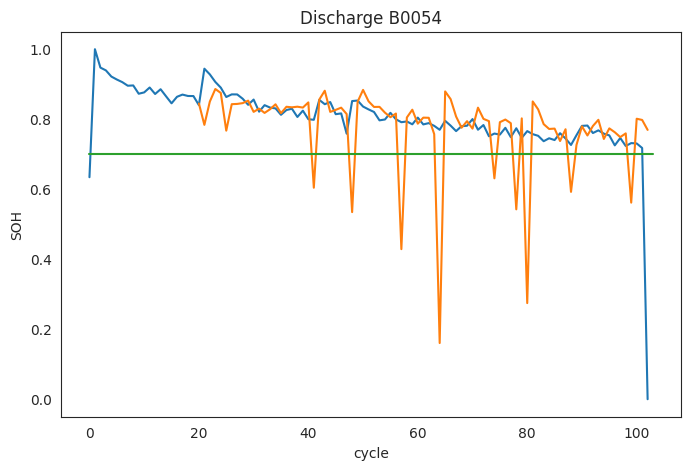

In [17]:
test_battery_id = 'B0054'
# save_path = save_path
save_path = 'model/float_model/seq20_last.pth'

test_battery_path = test_directory+ test_battery_id + '.mat'
test_data,test_data_real = data_loader(test_battery_path,seq_len,features)
# load
lstm = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
lstm.load_state_dict(torch.load(save_path))
lstm.eval()
output = lstm(test_data)
predicted_data = output.detach().numpy().reshape(-1)
print(predicted_data.shape)

# draw
origin_data = norm_data(test_battery_path) # dictionary
sns.set_style("white")
plt.figure(figsize=(8, 5))
#Draw
plt.plot([i for i in range(len(origin_data['SOH']))], origin_data['SOH'], label='SOH')
# predicted_data = np.concatenate((origin_data['SOH'][0:seq_len],predicted_data), axis = 0)
plt.plot([i for i in range(seq_len,len(origin_data['SOH']))], predicted_data, label='Predicted SOH')
plt.plot([0.,len(origin_data['SOH'])], [0.70, 0.70], label='Threshold')

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.ylabel('SOH')
plt.title('Discharge {}'.format(test_battery_id))


MAE =  np.mean(np.abs(predicted_data - origin_data['SOH'][seq_len:]))
MAPE = np.mean(np.abs((origin_data['SOH'][seq_len:] - predicted_data) / origin_data['SOH'][seq_len:]))
MSE = np.mean((predicted_data - origin_data['SOH'][seq_len:]) ** 2)
RMSE = np.sqrt(MSE)
print('MAE:{}'.format(MAE))
print('MAPE:{}'.format(MAPE))
print('MSE:{}'.format(MSE))
print('RMSE:{}'.format(RMSE))

In [4]:
  # use GPU if available   
if (torch.cuda.device_count() > 0):
    print('You have',torch.cuda.device_count(),'CUDA devices available')
    for i in range(torch.cuda.device_count()):
        print(' Device',str(i),': ',torch.cuda.get_device_name(i))
    print('Selecting device 0..')
    device = torch.device('cuda:0')
else:
    print('No CUDA devices available..selecting CPU')
    device = torch.device('cpu')
    # load trained model
float_model = './model' + '/float_model'
float_model = os.path.join(float_model,'seq20_last.pth')
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers).to(device)
model.load_state_dict(torch.load(float_model))

# test
val_dataset = LoadDataset(val_directory, seq_len=seq_len, features=features)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
# model.eval()
# with torch.no_grad():
#     for test_data, test_data_real in val_dataloader:
#         test_data = torch.squeeze(test_data).to(device)
#         test_data_real = torch.squeeze(test_data_real).to(device)
#         test_output = model(test_data)
#         test_output = torch.squeeze(test_output)
# 
#         print('---------------------------------')
#         RMSE = torch.sqrt(torch.mean((test_output - test_data_real)**2))
#         print('RMSE:{}'.format(RMSE))

test(model,device,val_dataloader)

You have 1 CUDA devices available
 Device 0 :  NVIDIA GeForce RTX 2060
Selecting device 0..
---------------------------------
RMSE:0.02255389280617237
---------------------------------
RMSE:0.020436136052012444
---------------------------------
RMSE:0.14397622644901276
